---
# 4. Simulation
---

Armed with the theory of the data generating process and the variance of the principal component regression coefficients, I examine how $\text{Var}(\hat{\beta_s})$, $\text{Var}(\hat{\beta_t})$ and $\text{Var}(\hat{Y_i})$ behave for different sample sizes. The results show that if the strategy from equation *(3.24)* is used to compute the $\text{Var}(\hat{\beta_s})$, the results for $\text{Var}(\hat{\beta_s})$ and $\text{Var}(\hat{\beta_t})$ do not differ.  

## 4.1 Simulate the whole Population

First I simulate the whole population. The full parameterization is given and justified in the appendix *A.10*. I have wrapped the whole data generating process in a function. The whole function can be found in the Github repository's folder ['R'](https://github.com/manuhuth/PCR-Parameter-Variance-Analysis/tree/master/R) in the file *DGP_function*. Since the data set is very large I decided to simulate it in advance and to upload the data to Github in three parts to meet the size requiremnst of GitHub. It is located in the folder ['SimData'](https://github.com/manuhuth/PCR-Parameter-Variance-Analysis/tree/master/SimData). The code I used to simulate is given in the next cell. If desired, also a smaller number of the population size yields reasonable reults. I have listed the inputs in the same order as they appear in Table 2 in the appendix. The function additionally allows to tune the optimization to obtain the logarithmic wage, which is not of greater concern for my purposes but facilitates implementations of further analysis.

In [81]:
#At the end set this on top of the notebook
options(repr.plot.width=8, repr.plot.height=4) #adjust plot size

setwd('C:/Users/Mhuth/Desktop/PCRPVA') #set your wordking directory to the name of the folder that your forked from GitHub
files <- c('PCA_PropVar', 'PCA', 'PCR_cv', 'PCR_predict', 'PCR', 'random_discreteVariables', 'random_VCV', 'DGP_function', 'plot_functions', 'coef_var_analysis', 'OLS_estimate') #define all files with functions to read from the foldr 'R'
for (i in 1:length(files)) { #loop to read all files
  source(paste('R/', files[i], '.R', sep = ''))
}

library(readxl) #Only necessary if own data is simulated
library(ggplot2) #plotting library
library(gridExtra) #extension to ggplot2

In [41]:
set.seed(123) #set random seed to ensure reproducibility
N <- 2300000 #set number of Observations. To test the Notebook, a small sample can be used. N = 1000 already yields reasonable results. However, this must be taken into account in the simulation study.

#simulate population. Since this takes long to execute, I have used a pre-simulated example that has been simulated using the subsequent code
#population <- dgp_model(var_ability = 1, max_age = 68, min_age = 33, n = N, prob_numbSiblings = 0.1, mean_numberSiblings = 1.692, var_numberSiblings = 2.89,
#                      mean_parent_educ = 13.342, variance_parent_educ = 21.215,
#                      gamma_ability = 2,  gamma_parent_educ = 2,
#                      breaks_test7_m = c(0, 0.141, 0.158, 0.185, 0.190, 0.212),  breaks_test11_m = c(0, 0.122,0.152, 0.157, 0.179, 0.199),
#                      breaks_test7_r =  c(0, 0.166, 0.179, 0.188, 0.187, 0.165),  breaks_test11_r = c(0, 0.132, 0.163, 0.163, 0.176, 0.176), test_cat = TRUE, var_err = 1,
#                      beta_min = c(0.03, 0.01, -0.06, -10, 0.01), mean_wage = 2.040, variance_wage = 1.5,  beta_max = c(0.06, 0.06, -0.03, 10, 10), tau = 0.5,  
#                      max_yearsSchooling = 29,  mean_schooling = 13.342, variance_schooling = 21.215, min_yearsSchooling = 0, q = 0.85,
#                      age_school_count = 4, probs_gap = c(0.59, 0.11,0.7,0.04, 0.03), gap_years = c(0,1,2,3,4))

#load simulated data in three parts, since otherwise it is too huge for GitHub
load('SimData/population1.Rda')
load('SimData/population2.Rda')
load('SimData/population3.Rda')
population <- as.data.frame(cbind(population1, population2, population3)) #make one data frame out of the three uploaded data frames

X <- population[c('test7_m', 'test11_m', 'test7_r', 'test11_r', 'parent_educ', 'schooling', 'numb_Siblings', 'working')] #define matrix of covariates for the regression
X <- cbind(X, X$working^2/100) #include squared working years divided by 100
colnames(X) <- c('test7_m', 'test11_m', 'test7_r', 'test11_r', 'parent_educ', 'schooling', 'numb_Siblings', 'working', 'working_squ') #set colnames of matrix of covariates

**TO-DO** histograms of unstandardized variables to appendix

Since I use normalized variables for PCA and PCR I only report the variance-covariance matrix of the normalized variables. I normalize to obtain a matrix of covariates that consists, as introduced in section *3*, of column vectors for which each cell of one vector come from the same distribution with mean zero. The variance covariance matrix is computed using N degree of freedomns, since the matrix consisting of the covariates is the whole population and not only a sample, such that the mean is known and has not to be estimated. The correlation matrix is obtained as in the appendix A.11, equation *(a.23)* by matrix multiplication of the variance covariance matrix and a matrix that has zero on the off-diagonals and one divided by the k-th standard deviation as k-th diagonal element

In [42]:
trans <- 'normalized' #indicate if data is normalized or standarized
if (trans == 'normalized') {
    X_stand <- scale(X, center = TRUE, scale = FALSE)  #normalization
} else {
    X_stand <- scale(X, center = TRUE, scale = TRUE)  #standardization
}

VCV <- t(X_stand)%*%X_stand/(N) #compute true variance covariance matrix. Since this is the wole population, I use N and not (N-1) in the denominator.
corr <-  diag(diag(VCV)^(-0.5)) %*% VCV %*% diag(diag(VCV)^(-0.5)) # H %*% \Sigma %*% H, as in equation a.23
colnames(corr) <-  c('test7_m', 'test11_m', 'test7_r', 'test11_r', 'parent_educ', 'schooling', 'numb_Siblings', 'working', 'working_squ')
rownames(corr) <-   c('test7_m', 'test11_m', 'test7_r', 'test11_r', 'parent_educ', 'schooling', 'numb_Siblings', 'working', 'working_squ')

It can be observed that, as desired in the data generating process, many variables, especially the test scores are highly correlated with the other variables. Working and its squred variable divided by 100 are close to be perfect multicollinear. This high multicollinearity would increase the variance of the OLS estimate.  

**Table X.X - Correlation of the Normalized Variables for the whole Population**

In [43]:
corr

,test7_m,test11_m,test7_r,test11_r,parent_educ,schooling,numb_Siblings,working,working_squ
test7_m,1.0000000,0.9136825,0.8401732,0.8031944,0.6189129,0.7199581,-0.16977309,-0.28242918,-0.27361457
test11_m,0.9136825,1.0000000,0.8053239,0.7977492,0.6217446,0.7197358,-0.16992051,-0.28203734,-0.27220329
test7_r,0.8401732,0.8053239,1.0000000,0.9097965,0.6242374,0.7254468,-0.17085071,-0.28432302,-0.27404970
test11_r,0.8031944,0.7977492,0.9097965,1.0000000,0.6220999,0.7202347,-0.16941423,-0.28228197,-0.27180700
parent_educ,0.6189129,0.6217446,0.6242374,0.6220999,1.0000000,0.9081710,-0.27200745,-0.35526466,-0.33629268
schooling,0.7199581,0.7197358,0.7254468,0.7202347,0.9081710,1.0000000,-0.24718518,-0.39131193,-0.37153867
numb_Siblings,-0.1697731,-0.1699205,-0.1708507,-0.1694142,-0.2720074,-0.2471852,1.00000000,0.09682776,0.09172515
working,-0.2824292,-0.2820373,-0.2843230,-0.2822820,-0.3552647,-0.3913119,0.09682776,1.00000000,0.98221477
working_squ,-0.2736146,-0.2722033,-0.2740497,-0.2718070,-0.3362927,-0.3715387,0.09172515,0.98221477,1.00000000


From the variance-covariance matrix we can compute the true matrix of eigenvectors $\pmb \phi$ and eigenvalues $\lambda$.

In [44]:
phi <- eigen(VCV)$vectors #compute eigenvectors of the variance covariance marix -> one solution from 2^ = 256
lambda <- eigen(VCV)$values ##compute eigenvalues of the variance covariance marix -> unique

**Table X.X - Eigenvectors of the whole Population Variance-Covariance Matrix of the Standardized Variables**

In [45]:
phi #show true matrix of eigenvectors

-0.03678433,-0.15246801,-0.38216836,0.27034521,-0.28953153,0.23266930,0.5987336044,-0.3466799476,3.736694e-01
-0.02368081,-0.09817898,-0.22972758,0.16087334,-0.16196055,0.13357140,0.3564106359,0.5852664406,-6.304817e-01
-0.03662777,-0.15207487,-0.37408992,0.26346558,-0.26917992,0.23167744,-0.6174200050,-0.3717652036,-3.473113e-01
-0.02340266,-0.09701501,-0.22513547,0.15690048,-0.15242750,0.13144721,-0.3649158361,0.6315272608,5.850076e-01
-0.15422445,-0.69035893,0.44255912,-0.35671688,-0.34631134,0.23786560,-0.0013763621,0.0005949563,1.508259e-04
-0.15534360,-0.63262372,-0.29607322,0.11498264,0.53781727,-0.43040934,0.0060363364,-0.0154076180,1.334114e-03
0.01563757,0.07471323,-0.57153566,-0.81614867,-0.03257865,0.01897437,0.0003400773,-0.0004695482,-7.510714e-05
0.82734507,-0.18364733,-0.01572720,0.01324093,-0.32433204,-0.41968611,-0.0046915292,0.0007586692,-9.135251e-04
0.51335722,-0.13586417,0.01118289,-0.01610724,0.52803097,0.66237615,0.0076185159,-0.0012708048,1.503504e-03


## 4.2 Convergence of Eigenvectors and Eigenvalues

### 4.2.1 A Simple 2-Dimensional Graphical Illustration

Since the eigenvectors are 8-Dimensional, they cannot be illustrated in a graph. Hence, I decided to start with a 2-dimensional case to give a first intuition how $\hat{\pmb \phi}$ converges to $\pmb \phi$ if he sample size increases. Moreover, since the direction is invariant to the choice of the representant of $[\phi]$ the implementation in the two dimensional case is straightforward. For this purpose I decided to use the variables *years of schooling* and *years of parent's education*. I chose these two variables since they have a high correlation of 0.9082 and had the same scale in the unstandardized set-up.   

In [15]:
X_2D <- X[ , c('parent_educ', 'schooling' )] #choose two variables
pca_2D <- PCA(X_2D, transform = trans) #do principal components analysis (written by me)
phi_2D <- pca_2D$phi #get matrix of eigenvectors (not unique)
plot_2D <- ggplot(as.data.frame(pca_2D$X_transformed[1:500,]), aes(parent_educ, schooling)) + geom_point() + #I only plot the first 500 points since otherwise the graph would be overloaded with points
                geom_abline(aes(intercept = 0, slope = phi_2D[1,1]/phi_2D[2,1], colour = 'first eigenvector'), size = 1) +
                labs(colour = '') +
                scale_colour_manual(values=c('green', 'red')) +
                geom_abline(aes(intercept = 0, slope = phi_2D[1,2]/phi_2D[2,2], colour = 'second eigenvector'), size = 1)

**Table X.X - Eigenvectors of the VCV Matrix of Years of Parent's Education and Years of Schooling**

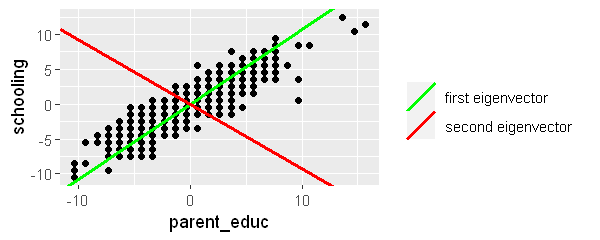

In [39]:
options(repr.plot.width=5, repr.plot.height=2) #adjust plot size
plot_2D #plo the graph

average eigenvectors make no sense -> just increase sample size. Convergence in Probability?

In [17]:
set.seed(1234) #set seet to ensure reporducibility
sample_size_2D <- c(20, 100, 500, 2000, 5000, 8000) #determine number of each sample size
plots_2D <- lapply(sample_size_2D, plot_2D_data, true_phi = phi_2D, true_X = X_2D, legend = TRUE, transform = trans) #use lapply function to plot graphs using the function plot_2D_data
legend <- cowplot::get_legend(plots_2D[[1]] + theme(legend.position = "bottom")) #cowplot::otherwise cowplot's ggplot theme is loaded
p_grid <- cowplot::plot_grid(plotlist = plots_2D, ncol = 3) #store plots in a grid

**Table X.X - Convergence of the Direction of Eigenvectors of Years of Parent's Education and Years of Schooling by Increasing the Sample Size**

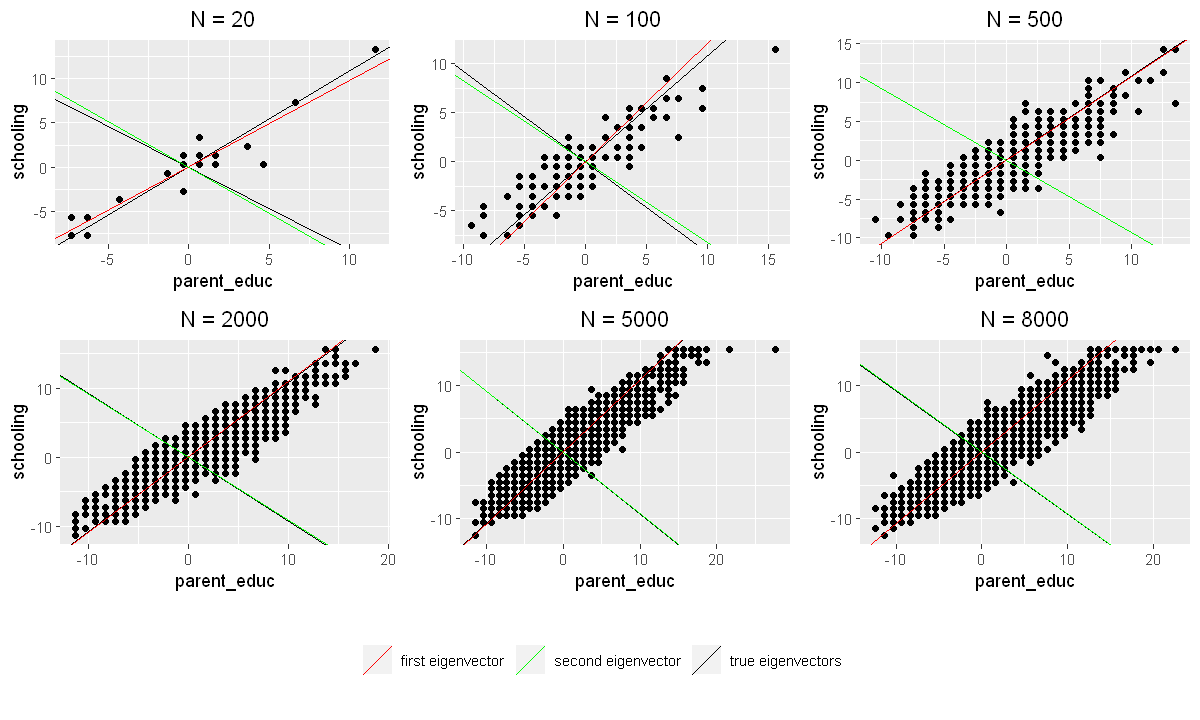

In [38]:
options(repr.plot.width=10, repr.plot.height=6) #adjust plot size
cowplot::plot_grid(p_grid, legend, ncol = 1, rel_heights = c(1, 0.2)) #plot plots from grid

## 4.3 Variance of the PCR Coefficients $\hat{\beta}$ in a Simulation Study

The question on how to compute the variance of the estimator arises. I will show two possibilities to compute the variance of the case using the $[\phi]$ class and the case using the estimated class of phi $[\hat{\phi}]$. If the notation $\hat{\beta}$ is used in this section, this indicates that the given statement holds for $\hat{\beta_s}$ and $\hat{\beta_t}$. 

What I do:
1. Difference between prac and prac with formula. would expect that prac is higehr due to problem of non-uniqueness of phi hat
2. Difference between theo and theo formula. would expect no difference since phi is chosen a priori
with one and two i have established that i can compare prac formula and theo formula
3. difference between prac formula and theo formula. what I wanted to look at.
4. show (for completeness how variance of Y changes)

explain everything briefly. with the formulas from section 3

say that prac vs theo does not make sense, since prac has issue with choice of phi

In [48]:
sample_size <- c(50,80,100,150, seq(200, 5000, by = 200)) #decide on which sample sizes should be analyzed
set.seed(12345) #set seet to ensure reporducibility
population_Y <- cbind(population$logwage, X) #create matrix including the log-wages
M <- 9 # do it for all since it does not change the other
numb_it <- 400 #define number of iterations to compute the mean of the variances

#use the lapply function to create the variances for each coefficient and sample size. Since this takes around one day, I chose to pre-simulate the dataand load it.
#variance_analysis_results <- lapply(sample_size, coef_var_analysis, population = population_Y, true_phi = phi, M = M, transform = trans, iterations = numb_it, numb_iterations = numb_it) 

load("SimData/results.Rda") #load the stored results from the folder 'SimData'
confidence <- 0.99 #set level of confidence in which interval the mean of the variance estimates should be with a confidence of 'confidence' 

#use the lapply function to prepare all the plots. computes means and confidence intervals of the means of the variances for all coefficients and all sample sizes
variance_plots_data_CI <- lapply(c(1:(length(variance_analysis_results[[1]]))), prepare_variances_plots_CI, list_variances = variance_analysis_results,
                                            sample_size = sample_size, confidence = confidence, type_CI = 'mean', numb_it = numb_it)

#set up plot to your taste
xlab <- 'Sample Size'
ylab <- 'Mean of Variance Estimate'
numb_columns <- 3 #number of columns per plot
col_prac_formula <- 'orange' #colour of the mean of the variance estimates of the estimates obtained by formula 3.24
col_prac <- 'blue' #colour of the mean of the variance estimates of the estimates obtained by formula 3.23 using stochastic phis
col_theo_formula <- 'green' #colour of the mean of the variance estimates of the estimates obtained by formula 3.25
col_theo <- 'red' #colour of the mean of the variance estimates of the estimates obtained by formula 3.24 using the true phi shown above

**Table X.X - Variance of $\hat{\beta_s}$ (Stochastic Phi) Computed with Formula 3.23 vs. Variance of $\hat{\beta_s}$ (Stochastic Phi) Computed with Formula 3.24**  

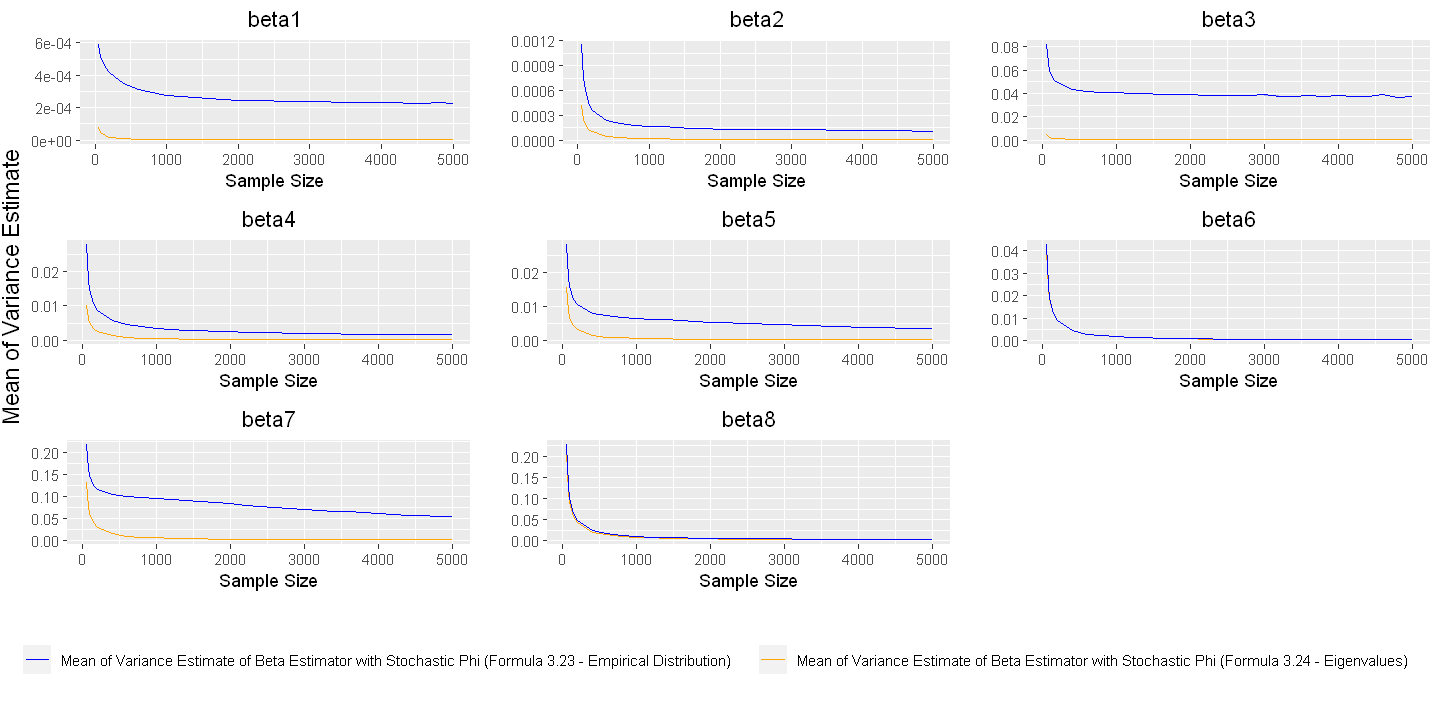

In [49]:
options(repr.plot.width=12, repr.plot.height=6) #adjust plot size
plots_variance_CI(variance_plots_data = variance_plots_data_CI, first_method = 'beta_prac_formula', second_method = 'beta_prac',
                  colour_1 = col_prac_formula, colour_2 = col_prac, xlab_string = xlab, ylab_string = ylab,
                  legend_df1 = 'Mean of Variance Estimate of Beta Estimator with Stochastic Phi (Formula 3.24 - Eigenvalues)',
                  legend_df2 = 'Mean of Variance Estimate of Beta Estimator with Stochastic Phi (Formula 3.23 - Empirical Distribution)',
                  numb_columns = numb_columns, sample_size = sample_size, subtitle = 'beta')

**Table X.X - Variance of $\hat{\beta_t}$ (True Phi) Computed with Formula 3.23 vs. Variance of $\hat{\beta_t}$ (True Phi) Computed with Formula 3.25**  

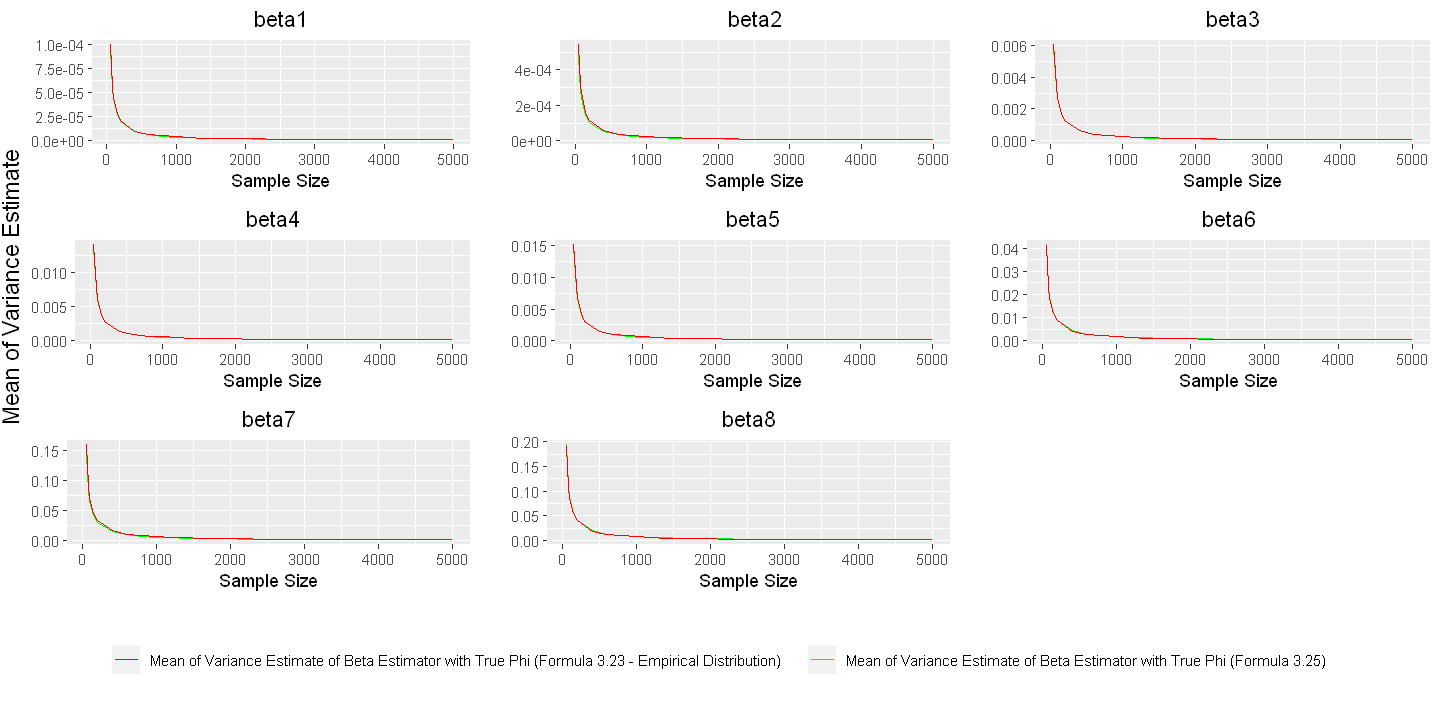

In [50]:
plots_variance_CI(variance_plots_data = variance_plots_data_CI, first_method = 'beta_theo_formula', second_method = 'beta_theo',
                  colour_1 = col_theo_formula, colour_2 = col_theo, xlab_string = xlab, ylab_string = ylab,
                  legend_df1 = 'Mean of Variance Estimate of Beta Estimator with True Phi (Formula 3.25)',
                  legend_df2 = 'Mean of Variance Estimate of Beta Estimator with True Phi (Formula 3.23 - Empirical Distribution)',
                  numb_columns = numb_columns, sample_size = sample_size, subtitle = 'beta')

**Table X.X - Variance of $\hat{\beta_t}$ (True Phi) Computed with Formula 3.25 vs. Variance of $\hat{\beta_s}$ (Stochastic Phi) Computed with Formula 3.24**  

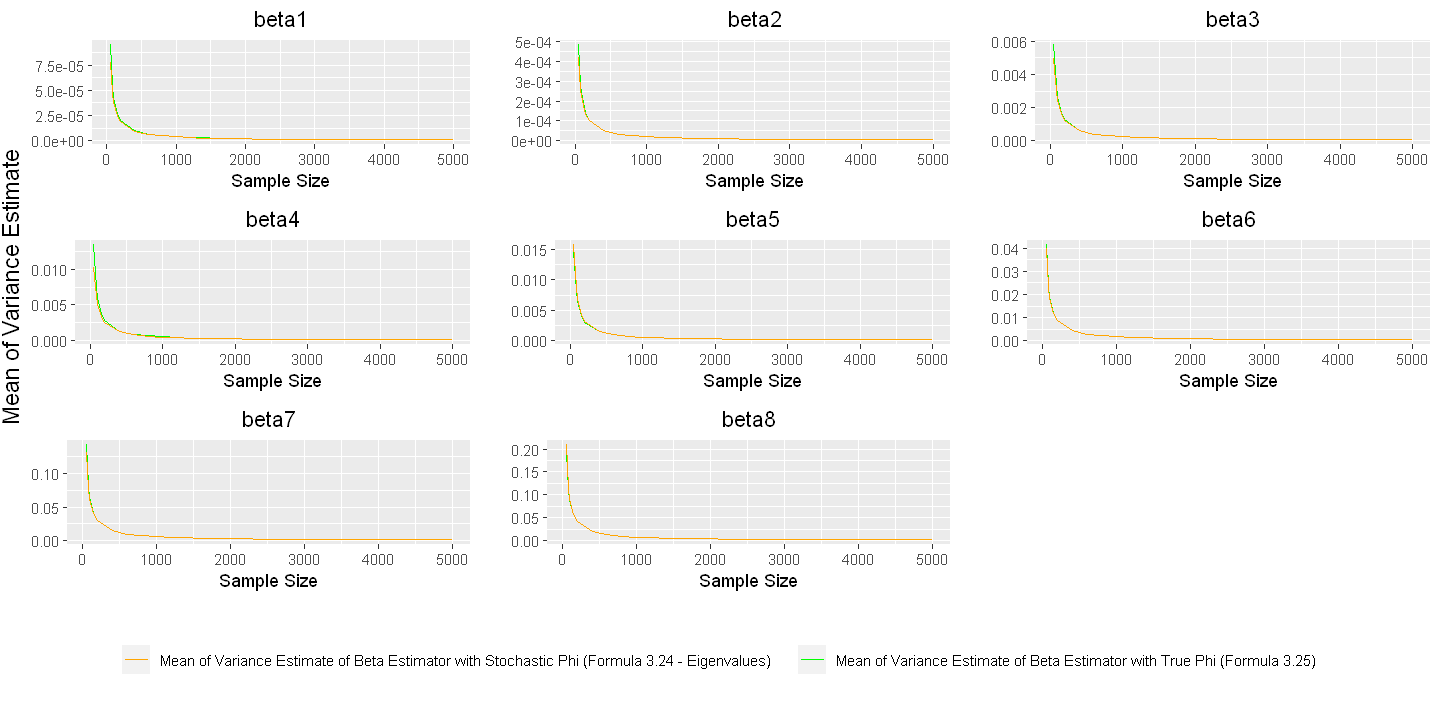

In [51]:
plots_variance_CI(variance_plots_data = variance_plots_data_CI, first_method = 'beta_theo_formula', second_method = 'beta_prac_formula',
                  colour_1 = col_theo_formula, colour_2 = col_prac_formula, xlab_string = xlab, ylab_string = ylab,
                  legend_df1 = 'Mean of Variance Estimate of Beta Estimator with True Phi (Formula 3.25)',
                  legend_df2 = 'Mean of Variance Estimate of Beta Estimator with Stochastic Phi (Formula 3.24 - Eigenvalues)',
                  numb_columns = numb_columns, sample_size = sample_size, subtitle = 'beta')

put one with 99 percent coverage in appendix

## 4.5 Variance of $\hat{Y}$

In [64]:
variances_Y_prac <- prepare_Y_variances(meth_interest = 'variances_Y_prac', list_variances = variance_analysis_results, confidence = confidence, numb_it = numb_it) #compute means and confidence intervals
variances_Y_theo <- prepare_Y_variances(meth_interest = 'variances_Y_theo', list_variances = variance_analysis_results, confidence = confidence, numb_it = numb_it) #compute means and confidence intervals
list_var_Y <- list(list('prac' = variances_Y_prac, 'theo' = variances_Y_theo)) #save all in one list that can be applied to the plots_variance_CI function

**Table X.X - Variance of $\hat{Y}_t$ (True Phi) vs. Variance of $\hat{Y}_s$ (Stochastic Phi)**  

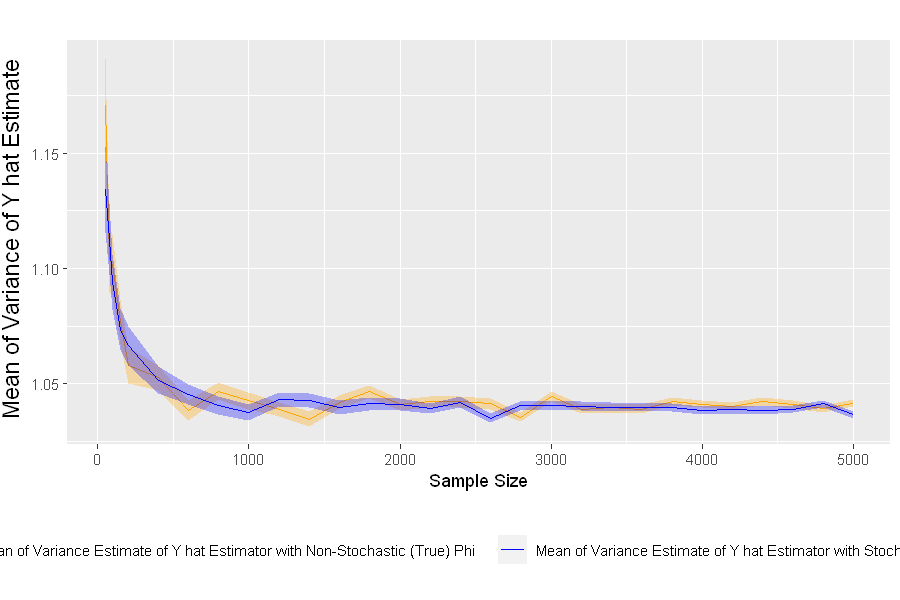

In [90]:
options(repr.plot.width=7.5, repr.plot.height=5) #adjust plot size
plots_variance_CI(variance_plots_data = list_var_Y, first_method = 'theo', second_method = 'prac',
                  colour_1 = 'orange', colour_2 = 'blue', xlab_string = 'Sample Size', ylab_string = 'Mean of Variance of Y hat Estimate',
                  legend_df1 = 'Mean of Variance Estimate of Y hat Estimator with Non-Stochastic (True) Phi',
                  legend_df2 = 'Mean of Variance Estimate of Y hat Estimator with Stochastic Phi',
                  numb_columns = 1, sample_size = sample_size, subtitle = 'Y', make_subtitle = FALSE)

compare to OLS

In [73]:
var_OLS <- var_Y_hat_OLS(population_Y = population_Y, sample_size = sample_size, confidence = confidence, numb_it = numb_it, print_it = FALSE)
list_var_Y_OLS <- list(list('prac' = variances_Y_prac, 'OLS' = var_OLS))

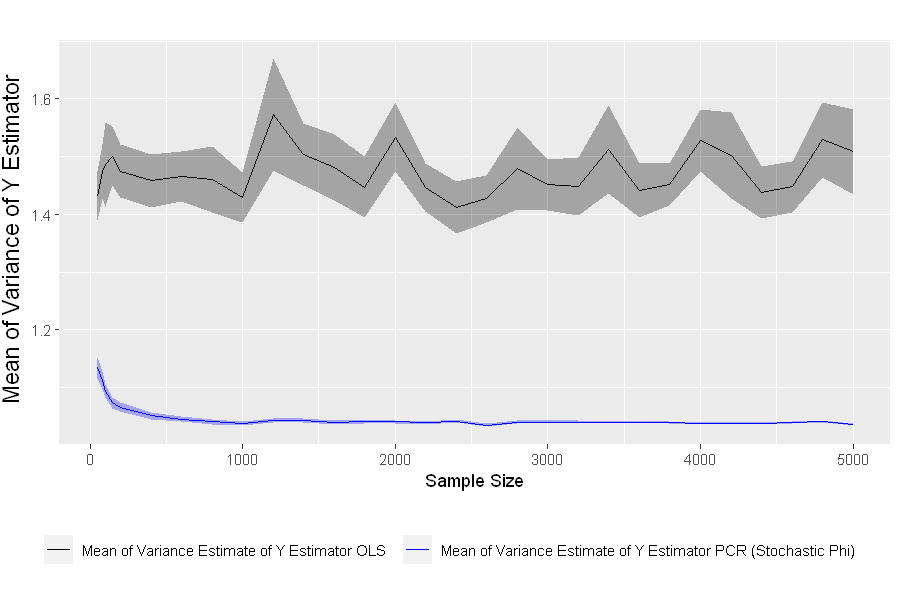

In [89]:
options(repr.plot.width=7.5, repr.plot.height=5) #adjust plot size
plots_variance_CI(variance_plots_data = list_var_Y_OLS, first_method = 'OLS', second_method = 'prac',
                  colour_1 = 'black', colour_2 = 'blue', xlab_string = 'Sample Size', ylab_string = 'Mean of Variance of Y Estimator',
                  legend_df1 = 'Mean of Variance Estimate of Y Estimator OLS',
                  legend_df2 = 'Mean of Variance Estimate of Y Estimator PCR (Stochastic Phi)',
                  numb_columns = 1, sample_size = sample_size, subtitle = 'Y', make_subtitle = FALSE)